# Twitter post classification - Good News or Bad News

**Lets import libraries**

In [1]:
%matplotlib inline
import wget
import zipfile
import os
import pandas as pd
import numpy as np
from itertools import *
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from preprocessor_arc import Arc_preprocessor
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.preprocessing import OneHotEncoder
import string
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from matplotlib import pylab
plt.rcParams.update({'font.size': 22})

In [2]:
if not os.path.exists('data'):
    os.makedirs('data', mode=0o777)
if not os.path.exists('embeddings'):
    os.makedirs('embeddings', mode=0o777)
    

**Declare Paths**

In [2]:
DATASET_URL = 'https://drive.google.com/uc?export=download&id=1kPfo7lk4FW5zCIETRs8goq5MEloyLUVy'
DATASET_PATH = 'data/good_bad_trainset.tsv'
EMBEDDING_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'
EMBEDDING_PATH = 'embeddings/crawl-300d-2M.vec.zip'

**Download dataset**

In [3]:
wget.download(DATASET_URL, DATASET_PATH) 


'data/goodvsbad_tweets (1).tsv'

**Download fasttext embeddings**

In [7]:
wget.download(EMBEDDING_URL, EMBEDDING_PATH)


'embeddings/crawl-300d-2M.vec.zip'

In [12]:
zip_ref = zipfile.ZipFile(EMBEDDING_PATH, 'r')
zip_ref.extractall(os.path.dirname(EMBEDDING_PATH))
zip_ref.close()

Now some setup, defining the transformer that transforms the essay data into word embeddings. This will be done word by word, and then the word vectors will be averaged to find the document mean vector.

**Data Loading and Analysis**

In [3]:
data_df = pd.read_csv(DATASET_PATH, sep='\t',
                        dtype={'tweet': object,  'id': np.int32,
                              'label': 'category'})

In [4]:
data_df[['tweet','label']].head(4)

,tweet,label
0,london man believed to be second patient to be...,1
1,three dead after truck driven into #stockholm ...,0
2,thousands are rallying against racism in #mace...,0
3,#irma gets stronger - potential cat hurrican...,0


In [5]:
import re
data_df[['tweet']] = data_df[['tweet']].replace(regex=r'http\S+', value='url')
data_df[['tweet']] = data_df[['tweet']].replace(regex=r't.co\S+', value='')
data_df[['tweet']] = data_df[['tweet']].replace(':', '')


In [6]:
data_df[['tweet','label']].head(4)

,tweet,label
0,london man believed to be second patient to be...,1
1,three dead after truck driven into #stockholm ...,0
2,thousands are rallying against racism in #mace...,0
3,#irma gets stronger - potential cat hurrican...,0


In [7]:
data_df.loc[data_df['label'] == '0'].tweet.head(4).values

array(['three dead after truck driven into #stockholm shoppers in suspected #terrorattack url : //  rzqis pb url : //  tmxh',
       "thousands are rallying against racism in #macerata , #italy today after last week's drive-by shooting by a neofascist that left six migrants and refugees wounded url : // ",
       '#irma gets stronger - potential cat   hurricane barrels over atlantic url : //  sgm #tcot #prepare',
       'hurricane irma intensifying to category   url : //  pbn #miami #reddit'],
      dtype=object)

In [8]:
data_df.loc[data_df['label'] == '1'].tweet.head(4).values

array(['london man believed to be second patient to be cured of infection with #hiv , the virus that causes aids url : //  mryiywz url : //  rmiblvrg',
       'recent study shows hiv intervention programs may be effective url : //  tc aqy w  via @njtvnews #njcri #hiv #prep #gettested #endaids #hivprevention #endhivstigma',
       'how to save stroke victims by analyzing data in motion url : // bit.ly/bzlyj  #iot',
       "firms boosting mobile traffic url : //on . wsj . com/pzzsjo wireless connected diapers ? babies have their own alert mechanisms don't they ? #iot"],
      dtype=object)

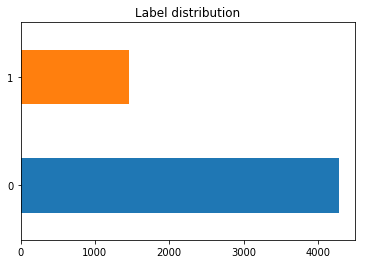

In [9]:
data_df['label'].value_counts().plot(kind='barh', title='Label distribution')

**Word frequency distrbution - unigram** - tries to communicate the frequency of the vocabulary in the text. Frequency distribution plot is word vs the frequency of the word. The frequency of the word can help us understand the topic of the corpus. Different genre of text can have a different set of frequent words, for example, If we have news corpus then sports news may have a different set of frequent words as compared to news related to politics, nltk has FreqDist class that helps to create a frequency distribution of the text corpus


In [10]:
arc_obj = Arc_preprocessor()
stopwords = nltk.corpus.stopwords.words('english')

In [11]:
stopwords= stopwords + ['url', 'hiv', 'macerata', 'hurricane', 'irma', 'harvey', 'iot', 'nintendo', 
                        'ebola', 'via', 'stockholm', 'internet', 'things', 'swachh', 'bharat', 'agu17', '//', ':']

In [12]:
bad_news_tweets = data_df.loc[data_df['label'] == '0'][['tweet']].values[:,0]
bad_news_tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in bad_news_tweets]

In [13]:
ravel_bad_news_tok_tweet = list(chain.from_iterable(bad_news_tok_tweet))

In [14]:
ravel_bad_news_tok_tweet = [word for word in ravel_bad_news_tok_tweet if word not in stopwords and word.isalpha() ]

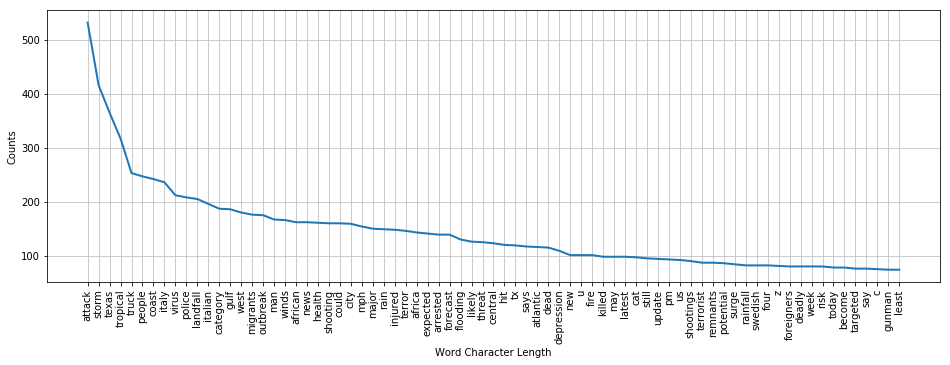

In [15]:
freqdist = nltk.FreqDist(ravel_bad_news_tok_tweet)
plt.figure(figsize=(16,5))
#plt.title('Word frequency distribution of not news tweet posts')
freqdist.plot(75)

In [16]:
good_news_tweets = data_df.loc[data_df['label'] == '1'][['tweet']].values[:,0]
good_news_tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in good_news_tweets]

In [17]:
ravel_good_news_tok_tweet = list(chain.from_iterable(good_news_tok_tweet))

In [18]:
print(ravel_good_news_tok_tweet[:10])

['london', 'man', 'believed', 'to', 'be', 'second', 'patient', 'to', 'be', 'cured']


In [19]:
ravel_good_news_tok_tweet = [word for word in ravel_good_news_tok_tweet 
                           if word not in stopwords and word.isalpha() ]


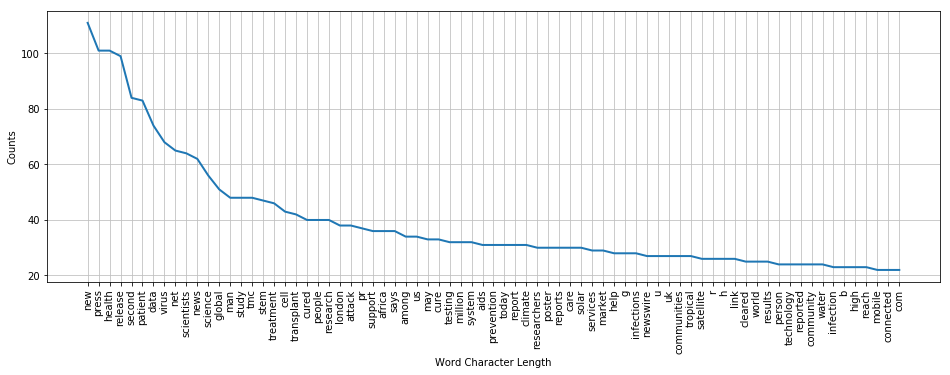

In [20]:
freqdist = nltk.FreqDist(ravel_good_news_tok_tweet)
plt.figure(figsize=(16,5))
#plt.title('Word frequency distribution of news tweet posts')
freqdist.plot(75)


**Word frequency distrbution - bigram**

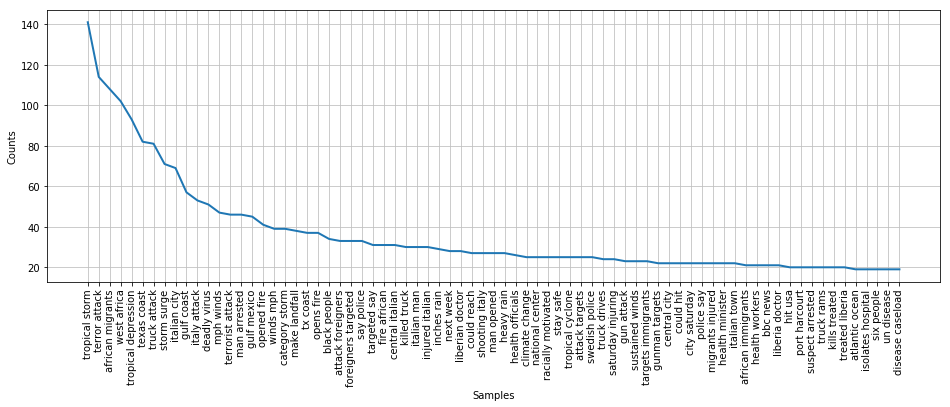

In [51]:
bigrams_bad_news_list = list(nltk.bigrams(ravel_bad_news_tok_tweet))
bigrams_bad_news_list = [' '.join(x) for x in bigrams_bad_news_list]
freqdist = nltk.FreqDist(bigrams_bad_news_list)
plt.figure(figsize=(16,5))
#plt.title('Word frequency distribution of not news tweet posts')
freqdist.plot(75)

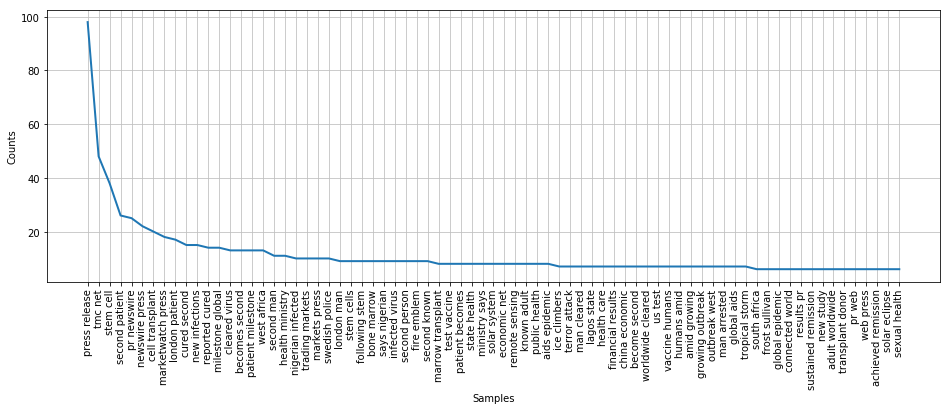

In [52]:
bigrams_good_news_list = list(nltk.bigrams(ravel_good_news_tok_tweet))
bigrams_good_news_list = [' '.join(x) for x in bigrams_good_news_list]
freqdist = nltk.FreqDist(bigrams_good_news_list)
plt.figure(figsize=(16,5))
#plt.title('Word frequency distribution of good news tweet posts')
freqdist.plot(75)

**Word Clouds** -  one of the simplest visualization technique which is a type of word frequency visualization. The size of the word in the image is bigger for more frequent word and smaller for less frequent word. This type of visualization can be of help in initial query formation. There are some drawbacks like the longer word may occupy more space giving the impression of the frequent word than it actually is. It may not help us to compare two frequent words about their relationship can be misleading sometimes even if using two words together may make sense. Frequent words may not be meaningful. For generating word cloud I am going to use wordcloud package you can install the package from pip. Below is the code to generate cloud


In [17]:
from wordcloud import WordCloud
from PIL import Image


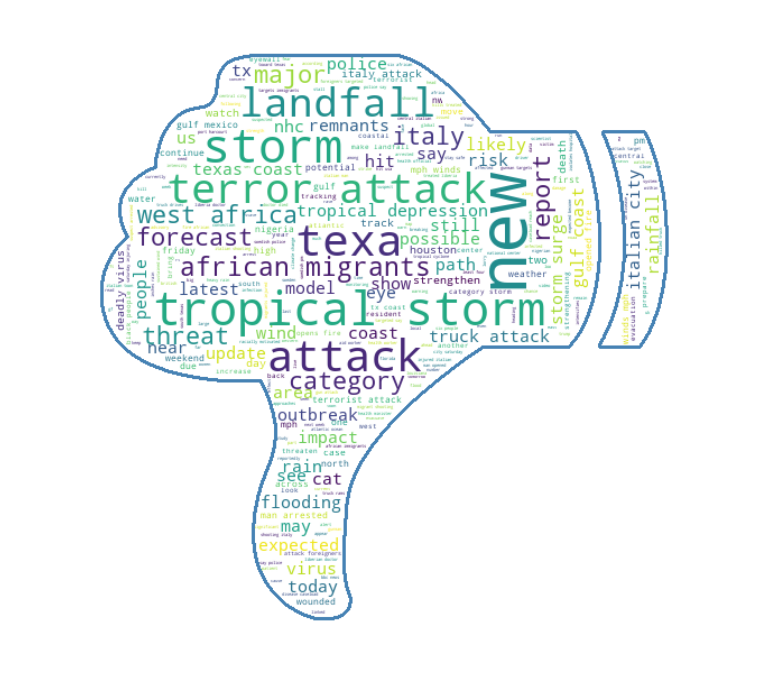

In [18]:
bad_news_text = ' '.join(ravel_bad_news_tok_tweet)
bad_mask = np.array(Image.open( "data/bad_news_mask.png"))
wordcloud = WordCloud(max_font_size=60, mask=bad_mask, contour_width=3, 
                      contour_color='steelblue', background_color="white", max_words=2000).generate(bad_news_text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
#plt.title("Not news Word Cloud")
plt.axis("off")
plt.show()


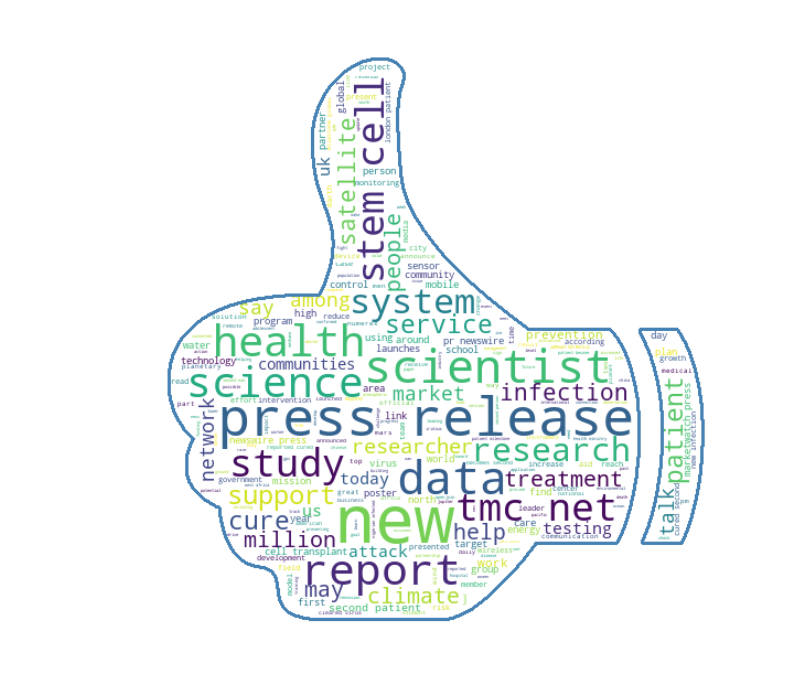

In [19]:
good_news_text = ' '.join(ravel_good_news_tok_tweet)
good_mask = np.array(Image.open( "data/good_news_mask.png"))
wordcloud = WordCloud(max_font_size=60, mask=good_mask, contour_width=3, 
                      contour_color='steelblue', background_color="white", max_words=2000).generate(good_news_text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
#plt.title("Good News Word Cloud")
plt.axis("off")
plt.show()


**Dispersion Plot** - this is the plot of a word vs the offset of the word in the text corpus.The y-axis represents the word. Each word has a strip representing entire text in terms of offset, and a mark on the strip indicates the occurrence of the word at that offset, a strip is an x-axis. The positional information can indicate the focus of discussion in the text

In [23]:
def dispersion_plot(text, text2, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    """

    try:
        from matplotlib import pylab
        plt.rcParams.update({'font.size': 22})
    except ImportError:
        raise ValueError(
            'The plot function requires matplotlib to be installed.'
            'See http://matplotlib.org/'
        )

    text = list(text)
    text2 = list(text2)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
        text2_to_comp = list(map(str.lower, text2))
    else:
        words_to_comp = words
        text_to_comp = text
        text2_to_comp = text2

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]
    points2 = [
        (x2, y2)
        for x2 in range(len(text2_to_comp))
        for y2 in range(len(words_to_comp))
        if text2_to_comp[x2] == words_to_comp[y2]
    ]
    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    if points:
        x2, y2 = list(zip(*points2))
    else:
        x2 = y2 = ()
    plt.figure(figsize=(16,8))
    pylab.plot(x, y, "b|", scalex=0.1, label='Tweet Bad News')
    pylab.plot(x2, y2, "r|", scalex=0.1, label='Tweet Good News')
    pylab.yticks(list(range(len(words))), words, color="k")
    pylab.ylim(-1, len(words))
    pylab.title(title)
    pylab.xlabel("Word Offset")
    pylab.legend()
    pylab.show()

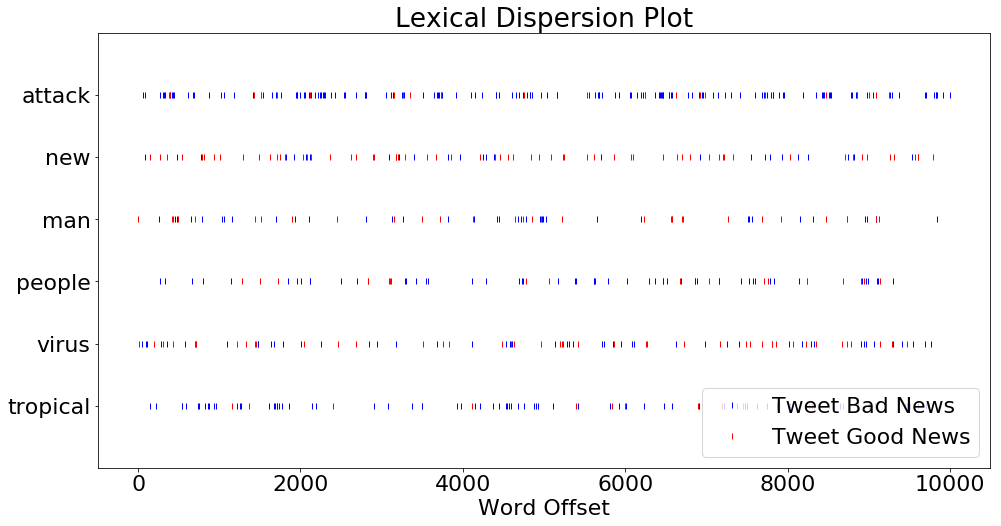

In [24]:
topics = ['attack','new','man','people','virus', 'tropical']
dispersion_plot(ravel_bad_news_tok_tweet[:10000], ravel_good_news_tok_tweet[:10000], topics)

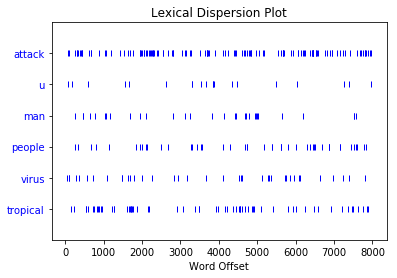

In [57]:
topics = ['attack','u','man','people','virus', 'tropical']
nltk.Text(ravel_bad_news_tok_tweet[:8000]).dispersion_plot(topics)

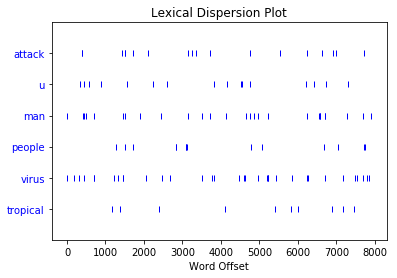

In [59]:
topics = ['attack','u','man','people','virus', 'tropical']
nltk.Text(ravel_good_news_tok_tweet[:8000]).dispersion_plot(topics)

**Lexical diversity dispersion** - lexical diversity lets us what is the percentage of the unique words in the text corpus for example if there are 100 words in the corpus and there are only 20 unique words then lexical diversity is 20/100=0.2.

In [25]:
def lexical_diversity(text):
    return round(len(set(text)) / len(text),2)



In [26]:
def lexical_array(corpus_array):
    print(lexical_diversity(corpus_array))
    total_words = 10001
    chunk_size = 1000
    j = 1
    x = []
    y = []
    for i in range(total_words):
        if i < j*chunk_size:
            pass
        else:
            ld = lexical_diversity(corpus_array[i-chunk_size:j*chunk_size])
            x.append(j*chunk_size)
            y.append(ld)
            #tuple_array.append([j*chunk_size, ld])
            j += 1
    return x,y
            
        

0.22
0.36


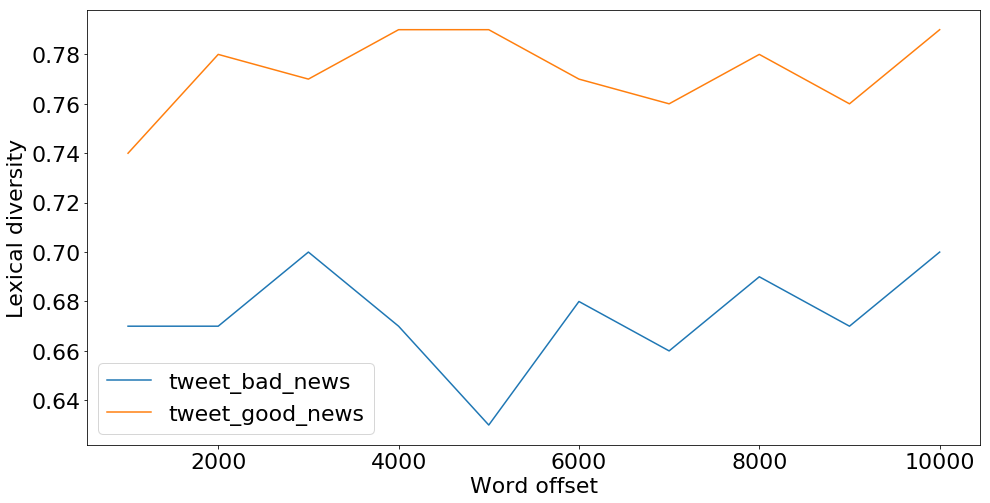

In [27]:
plt.figure(figsize=(16,8))
x2,y2 = lexical_array([x for x in ravel_bad_news_tok_tweet if x not in stopwords])
plt.plot(np.array(x2),np.array(y2), label='tweet_bad_news')
x3,y3 = lexical_array([x for x in ravel_good_news_tok_tweet if x not in stopwords])
plt.plot(np.array(x3),np.array(y3) ,label='tweet_good_news')
plt.legend()
plt.xlabel('Word offset')
plt.ylabel('Lexical diversity')
plt.show()

**Word length distribution** - This plot is word length on x-axis vs number of words of that length on the y-axis. This plot helps to visualise the composition of different word length in the text corpus

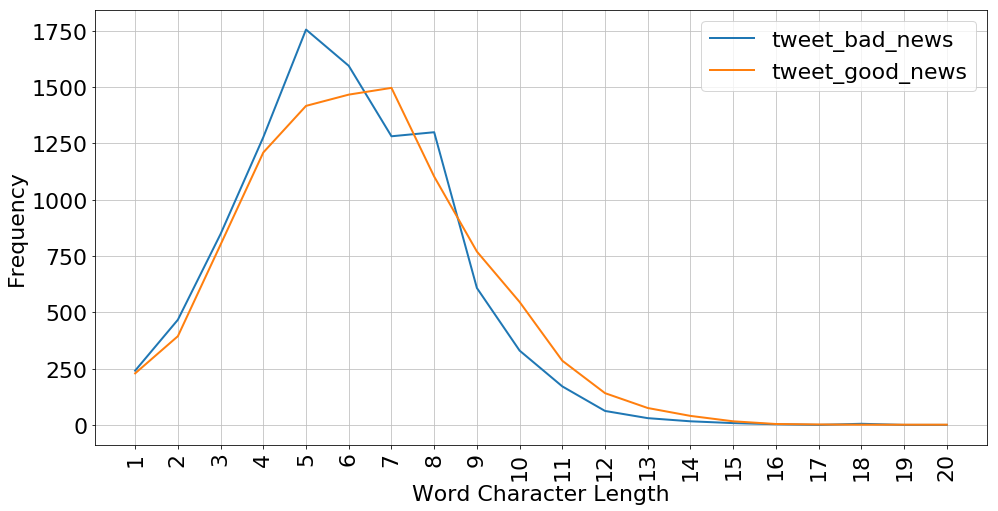

In [28]:
corpus_dict = {}

corpus_dict['tweet_bad_news'] = [x for x in ravel_bad_news_tok_tweet if x not in stopwords][:10000]
corpus_dict['tweet_good_news'] = [x for x in ravel_good_news_tok_tweet if x not in stopwords][:10000]

cfd = nltk.ConditionalFreqDist(
           (corpus_type, len(word))
           for corpus_type in corpus_dict.keys()
           for word in corpus_dict[corpus_type])

plt.figure(figsize=(16,8))
cfd.plot()


**N-gram frequency distribution** - n-grams is the continuous sequences of n words that occur very often for example for n=2 we are looking for 2 words that occur very often together like New York, Butter milk, etc. such pair of words are also called bigram, for n=3 its called trigram and so on. N-gram distribution plot tries to visualise distribution n-grams for different value of n, for this example, we consider n from 1 to 5. In the plot, x-axis has the different value of n and y-axis has the number of time n-gram sequence has occurred. Below is the code to plot the distribution plot.

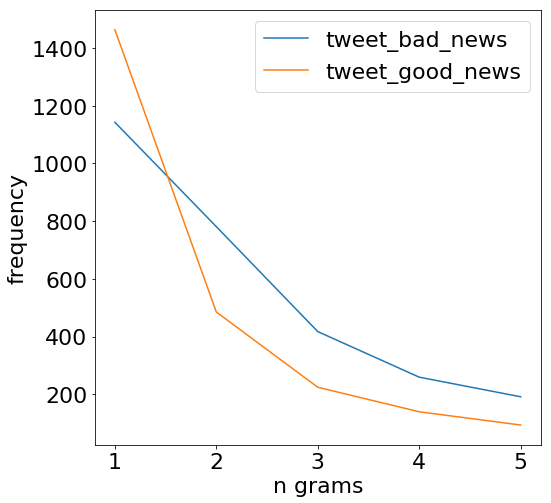

In [31]:
from nltk.util import ngrams
plt.figure(figsize=(8,8))
for corpus_type in corpus_dict.keys():
    sol = []
    for i in range(1,6):
        count = 0
        fdist = nltk.FreqDist(ngrams(corpus_dict[corpus_type], i))
        sol.append(len([cnt for ng,cnt in fdist.most_common() if cnt > 1]))
    plt.plot(np.arange(1,6), sol, label=corpus_type)
plt.ylabel('frequency')
plt.xlabel('n grams')
plt.legend()
plt.show()

**Data Preprocessing and Transformation**

In [162]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []
        #emb_path = EMBEDDING_PATH.replace('.zip','')
        emb_path = os.path.join(os.path.dirname(EMBEDDING_PATH),'offeneval_subtask_a.vec')
        with open(emb_path, 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        word_array = []
        for w in doc:
            if  w.lower().strip() in self._E:
                word_array.append(self._E[w.lower().strip()])
            else:
                word_array.append(np.zeros([len(v) for v in self._E.values()][0]))

        return np.mean(np.array(word_array), axis=0)
                
        #return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E else np.zeros([len(v) for v in self._E.values()][0])]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [163]:
def tokenize_and_transform(X, sample_size):
    tweets = X[:,0]
    arc_obj = Arc_preprocessor()
    tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in tweets[:sample_size]]
    #tok_tweet = [word_tokenize(doc) for doc in tweets[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_tweet)
    return X_transform

In [164]:
X = data_df[['tweet']].values
y = data_df['subtask_a'].values

In [165]:
X_transform = tokenize_and_transform(X, 160000)

**Data after transformation**

In [171]:
np.set_printoptions(threshold=5)
for i,tw in enumerate(X):
    print('%s:%s'%(tw[0],np.array(X_transform[i])))
    if i > 3:
        break

@USER She should ask a few native Americans what their take on this is.:[-0.23785868 -0.81432081 -0.59736057 ... -0.76759186  0.74580504
 -1.64158117]
@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL:[ 0.14161531 -0.55757464  0.42154353 ... -0.27313893  0.64572821
  0.21286828]
Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT:[ 0.61464088  0.90188339  0.15088314 ...  0.14194924  0.78256637
 -0.93532037]
@USER Someone should'veTaken" this piece of shit to a volcano. 😂":[-0.17469034 -0.18162627  0.95127902 ... -0.94913055  0.21175736
  0.79832478]
@USER @USER Obama wanted liberals &amp; illegals to move into red states:[ 2.5257941  -0.03132355 -0.60718661 ... -2.42689326  0.4544278
  2.67988114]


**Standardize features by removing the mean and scaling to unit variance**

In [167]:
scaler = StandardScaler()
X_transform = scaler.fit_transform(X_transform)

**Get label encodings**

In [168]:
le = LabelEncoder()
y = le.fit_transform(y)

**Data Split into train and test set**

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,
                                                    y, stratify=y, test_size=0.2, random_state=0)

**Model training and evaluation**

To determine if the dataset is unbalanced we can count the positive and negative cases. The number of positive cases is over two times the number of negative cases, which is very unbalanced, the AUC for the ROC curve or the F1 score would work fine for this dataset, but not regular accuracy.



In [170]:
def plot_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Precision score: {:3f}'.format(precision_score(y_test, y_pred, average='macro') ))
    print('Recall score: {:3f}'.format(recall_score(y_test, y_pred, average='macro') ))
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred, average='macro')))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Metric : %s' %(confusion_matrix(y_test, y_pred)))
    print('Prediction Accuracy: {:3f}'.format(accuracy_score(y_test, y_pred)))

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision score: 0.729671
Recall score: 0.685194
F1 score: 0.696542
AUC score: 0.685194
Confusion Metric : [[1573  195]
 [ 457  423]]
Prediction Accuracy: 0.753776


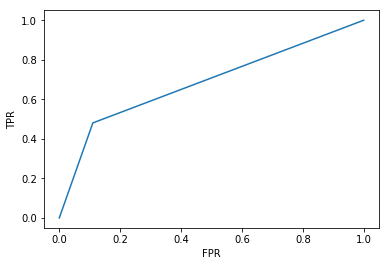

In [172]:
lr = LogisticRegression()
print_scores(lr, X_train, y_train, X_test, y_test)
plot_roc(lr, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Precision score: 0.758649
Recall score: 0.693367
F1 score: 0.707633
AUC score: 0.693367
Confusion Metric : [[1624  144]
 [ 468  412]]
Prediction Accuracy: 0.768882


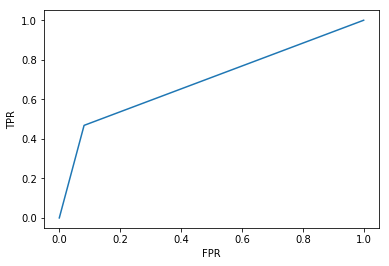

In [173]:
svc = SVC().fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test)
plot_roc(svc, X_test, y_test)